# Functional Connectivity - Degree Measures (NKI 1400, CompCorGSR, BNA)

In [1]:
import bct as bct
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting, regions, image

/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Set up notebook options and plotting functions.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set_context('notebook')

In [4]:
np.set_printoptions(suppress=True)

In [5]:
BNA_4D = image.load_img('/home/despoB/dlurie/Projects/timescale_hierarchy/viz/BNA_4D.nii.gz')

Load individual FC matrices.

In [6]:
subject_list = np.genfromtxt('/home/despoB/dlurie/Projects/timescale_hierarchy/data/meta/subject_lists/NKI-healthy_young.txt', dtype="U")

In [7]:
corrmat_CompCorGSR_fpt = '/home/despoB/nki_rs/data/derivatives/custom/sub-{0}/func/sub-{0}_ses-*_task-rest_acq-1400_bold_space-T1w_atlas-BNA_variant-CompCorGSR_corrmat.tsv'

In [8]:
corrmat_store = []
for sub_id in subject_list:
    data = np.loadtxt(glob(corrmat_CompCorGSR_fpt.format(sub_id))[0])
    np.fill_diagonal(data, 0)
    corrmat_store.append(data)
corrmat_store = np.array(corrmat_store)

## Group Average Network Centrality

Averaging brain networks across individuals is an effective way of reducing noise and avoiding the influence of spurious connections. This approach is common in brain network analysis, and was used in Power et al. 2013 when exploring different ways to define network hubs.

Load the group average network.

In [9]:
zmat_mean = np.genfromtxt('/home/despo/dlurie/Projects/timescale_hierarchy/results/functional_connectivity/NKI-1400_HY_CompCorGSR_BNA_zmat_mean.csv')

### Node Strength (weighted, positive edges only)

Calculate node strength from the group average network, considering only positive edges.

In [10]:
zmat_mean_po = zmat_mean.copy()

In [11]:
zmat_mean_po[zmat_mean_po < 0] = 0

In [12]:
strength_zmean_po = bct.degree.strengths_und(zmat_mean_po)

Visualize the spatial distribution of node strength.

In [13]:
strength_zmean_img = regions.signals_to_img_maps(strength_zmean_po, BNA_4D)

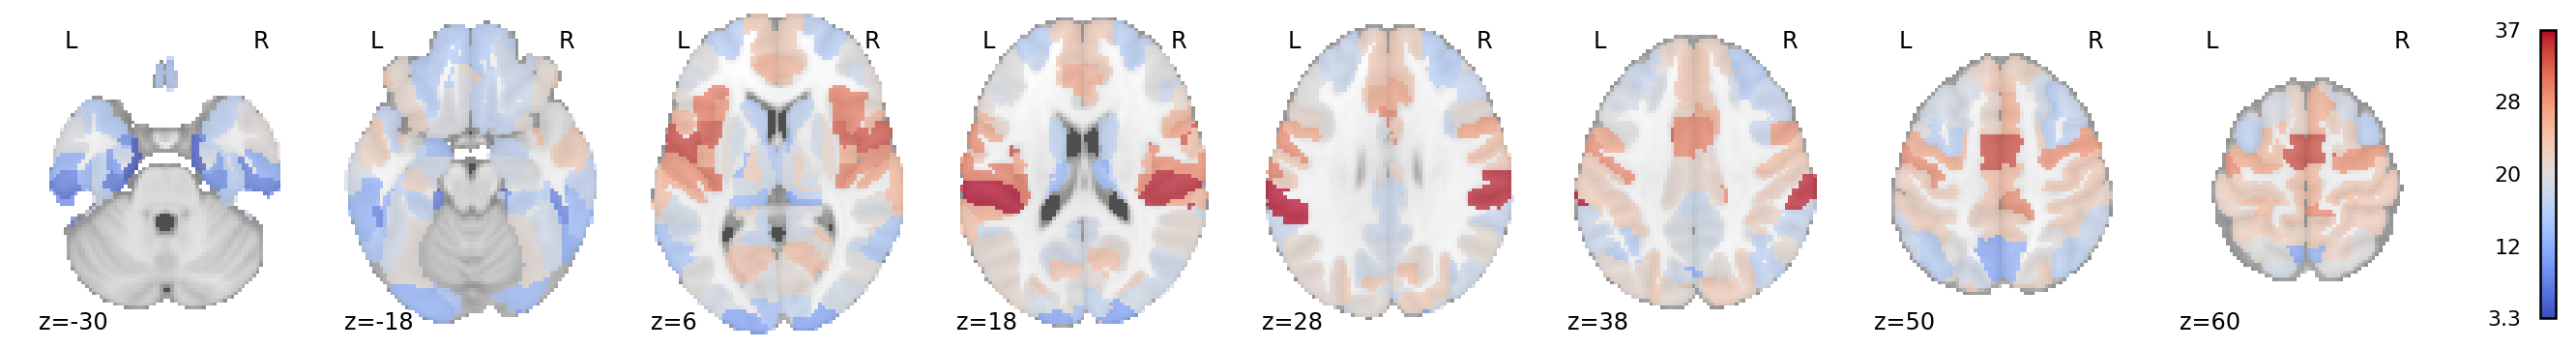

In [14]:
plotting.plot_roi(strength_zmean_img, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60], cmap='coolwarm', colorbar=True)

### Node Degree (binary, 5% edge density)

Calculate node degree from the group average binary network (thresholded at 5% edge density, as in Power et al., 2013). 

In [15]:
zmat_mean_95bin = zmat_mean.copy()

In [16]:
zmat_mean_95pctl = stats.scoreatpercentile(zmat_mean_95bin.flatten(),95)

In [17]:
zmat_mean_95bin[zmat_mean_95bin < zmat_mean_95pctl] = 0

In [18]:
zmat_mean_95bin = bct.degree.binarize(zmat_mean_95bin)

In [19]:
degree_zmean_95bin = bct.degree.degrees_und(zmat_mean_95bin)

Visualize the spatial distribution of node degree.

In [20]:
degree_zmean_zimg = regions.signals_to_img_maps(stats.zscore(degree_zmean_95bin), BNA_4D)

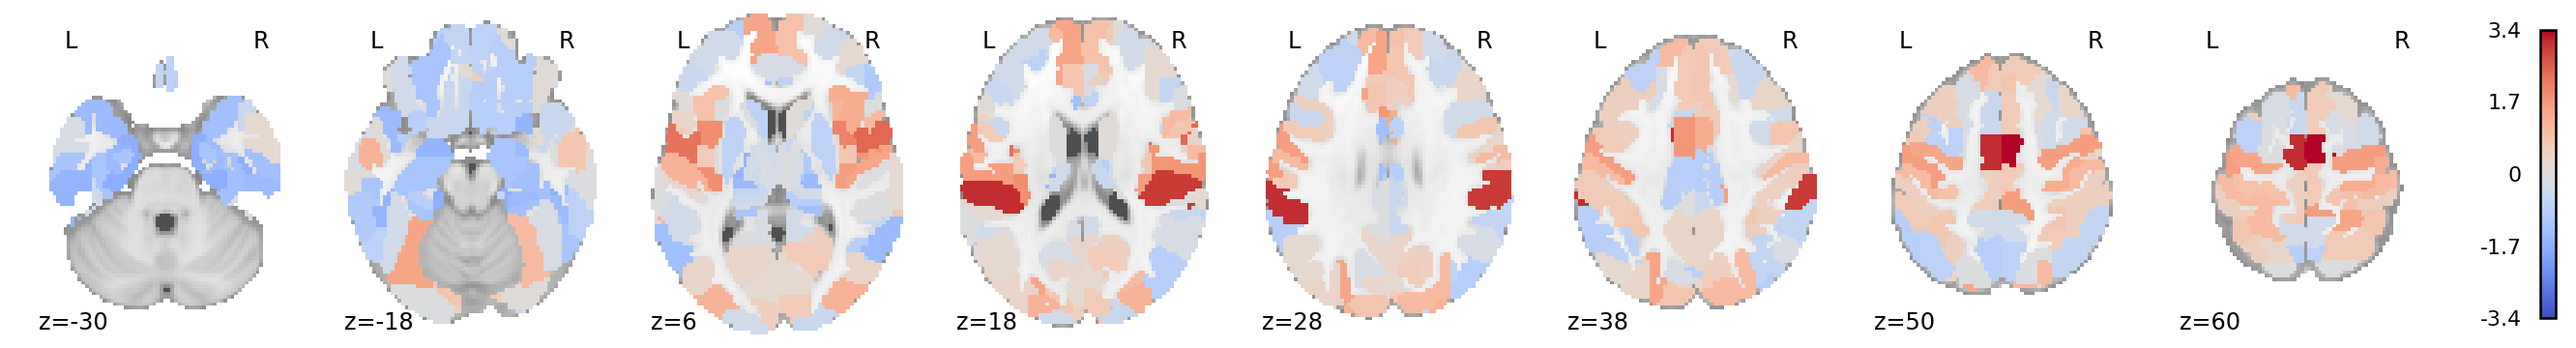

In [21]:
f = plotting.plot_stat_map(degree_zmean_zimg, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60], cmap='coolwarm', colorbar=True)

## Average of Single-Subject Centrality Measures

Buckner et al. (2009), Cole et al. (2010), and Zuo et al. (2012) calculate centrality measures for each individual and then take the average, instead of calculating these measures from a group-average network. Let us test if this approach gives us different results.

### Node Degree (Buckner et al. 2009)

Calculate node degree as in Buckner et al. 2009. Edges with strength less than r=0.25 are excluded, and the network is binarized. 

In [22]:
buckner_degz_store = []
buckner_store = corrmat_store.copy()
for corr_mat in buckner_store:
    corr_mat[corr_mat < 0.25] = 0
    buckner_degz_store.append(stats.zscore(bct.degree.degrees_und(bct.binarize(corr_mat))))
buckner_degz_store = np.array(buckner_degz_store)
buckner_degz_mean = np.mean(buckner_degz_store, axis=0)

Visualize the spatial distribution of node degree.

In [23]:
buckner_degz_img = regions.signals_to_img_maps(buckner_degz_mean, BNA_4D)

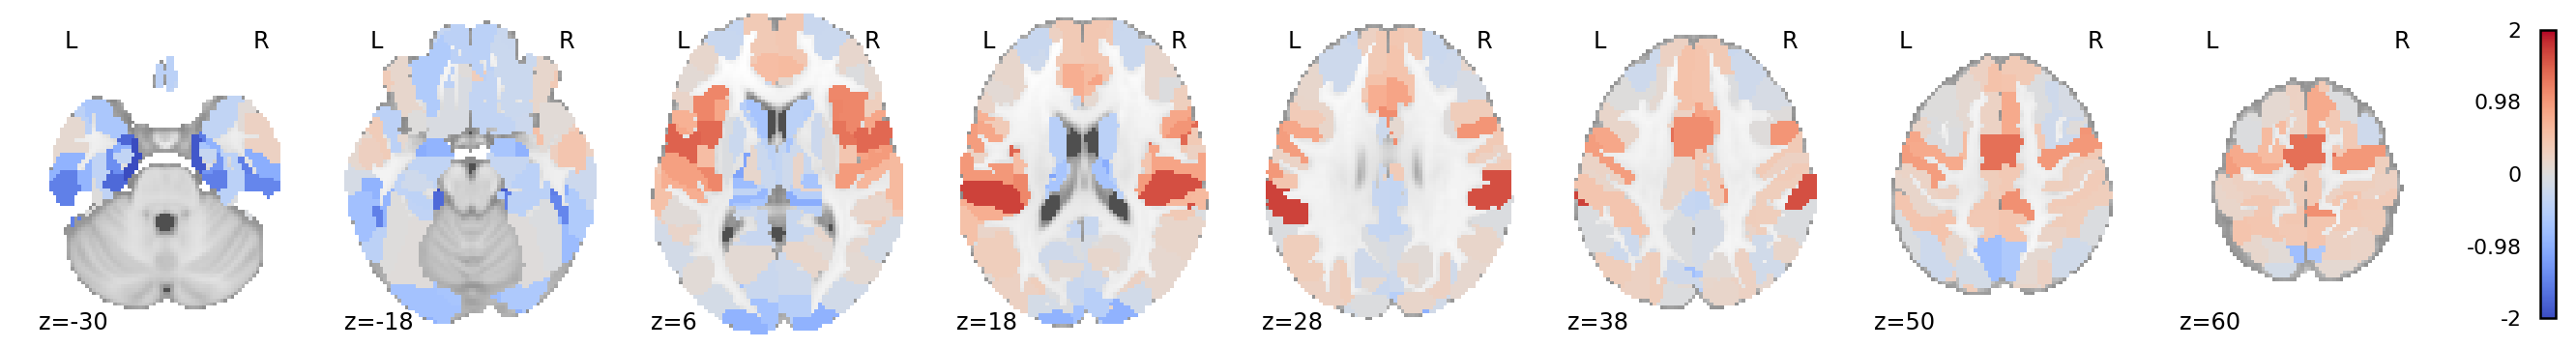

In [24]:
f = plotting.plot_stat_map(buckner_degz_img, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60], cmap='coolwarm', colorbar=True)

### Global Brain Connectivity (Cole et al., 2010)

Let's try the "Global Brain Connectivity" (GBC) measure from Cole et al. 2009. For each individual, correlations are transformed to z-scores. GBC for each region is the average of all z-scored edges. GBC values are then transformed back to correlations, before z-scoring across all regions. 

In [25]:
cole_gbcz_store = []
cole_store = corrmat_store.copy()
for corr_mat in cole_store:
    corr_mat = np.arctanh(corr_mat)
    cole_gbcz_store.append(stats.zscore(np.tanh(np.mean(corr_mat, axis=1))))
cole_gbcz_store = np.array(cole_gbcz_store)
cole_gbcz_mean = np.mean(cole_gbcz_store, axis=0)

Visualize the spatial distribution of GBC.

In [26]:
cole_gbcz_img = regions.signals_to_img_maps(cole_gbcz_mean, BNA_4D)

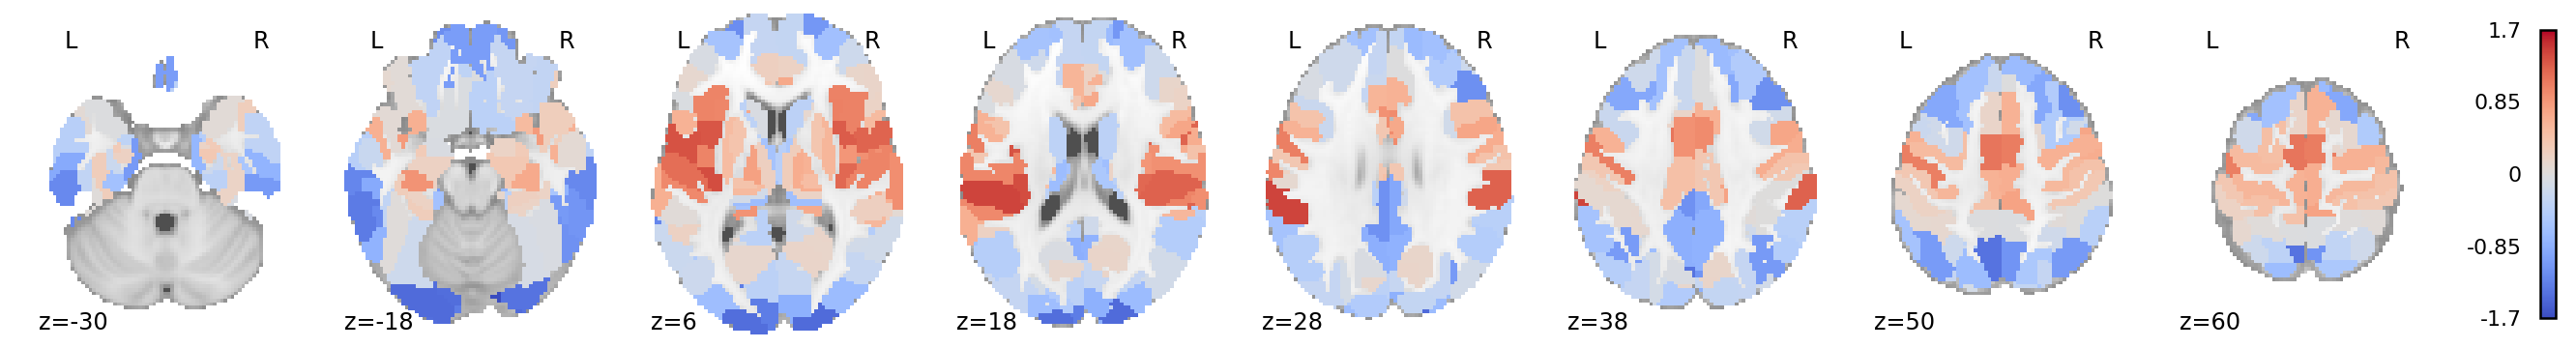

In [27]:
f = plotting.plot_stat_map(cole_gbcz_img, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60], cmap='coolwarm', colorbar=True)

Let's try the "Global Brain Connectivity" (GBC) measure from Cole et al. 2009. This is simply the average of all edges for each node. 

### Node Strength (Zuo et al. 2012)

Calculate node strength as in Zuo et al. 2012. Only edges where the correlation is p≤0.0001 (r≥0.1924 w/ N=404 timepoints; see the "Find FC Significance Thresholds" notebook) are included, and the matrix is then binarized.

In [28]:
zuo_strengthz_store = []
zuo_store = corrmat_store.copy()
for corr_mat in zuo_store:
    corr_mat[np.abs(corr_mat) < 0.1924] = 0
    corr_mat = bct.degree.binarize(corr_mat)
    zuo_strengthz_store.append(stats.zscore(bct.degree.degrees_und(corr_mat)))
zuo_strengthz_store = np.array(zuo_strengthz_store)
zuo_strengthz_mean = np.mean(zuo_strengthz_store, axis=0)

Visualize the spatial distribution of node degree.

In [29]:
zuo_strengthz_img = regions.signals_to_img_maps(zuo_strengthz_mean, BNA_4D)

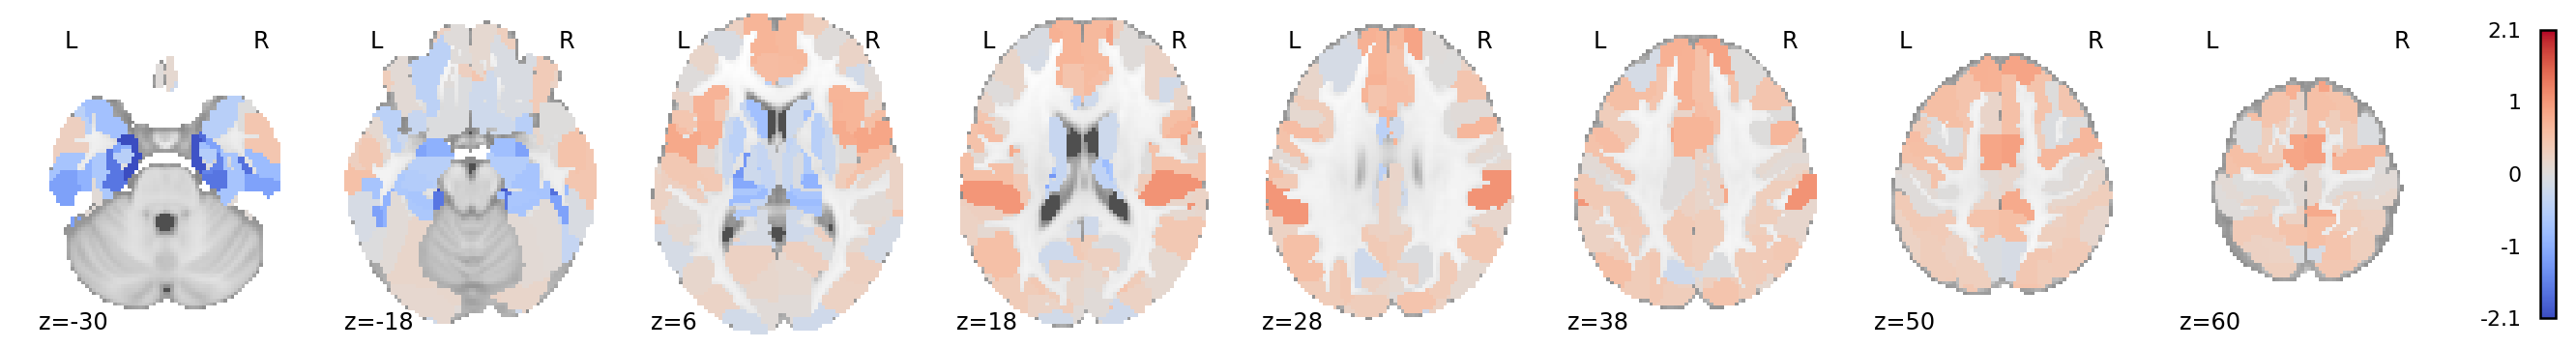

In [30]:
f = plotting.plot_stat_map(zuo_strengthz_img, display_mode='z', cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60], cmap='coolwarm', colorbar=True)

## Inter-individual variability

For good measure, let's also look at inter-individual variability for the single-subject measures.

In [31]:
buckner_degz_std = np.std(buckner_degz_store, axis=0)

In [32]:
buckner_degz_std_img = regions.signals_to_img_maps(buckner_degz_std, BNA_4D)

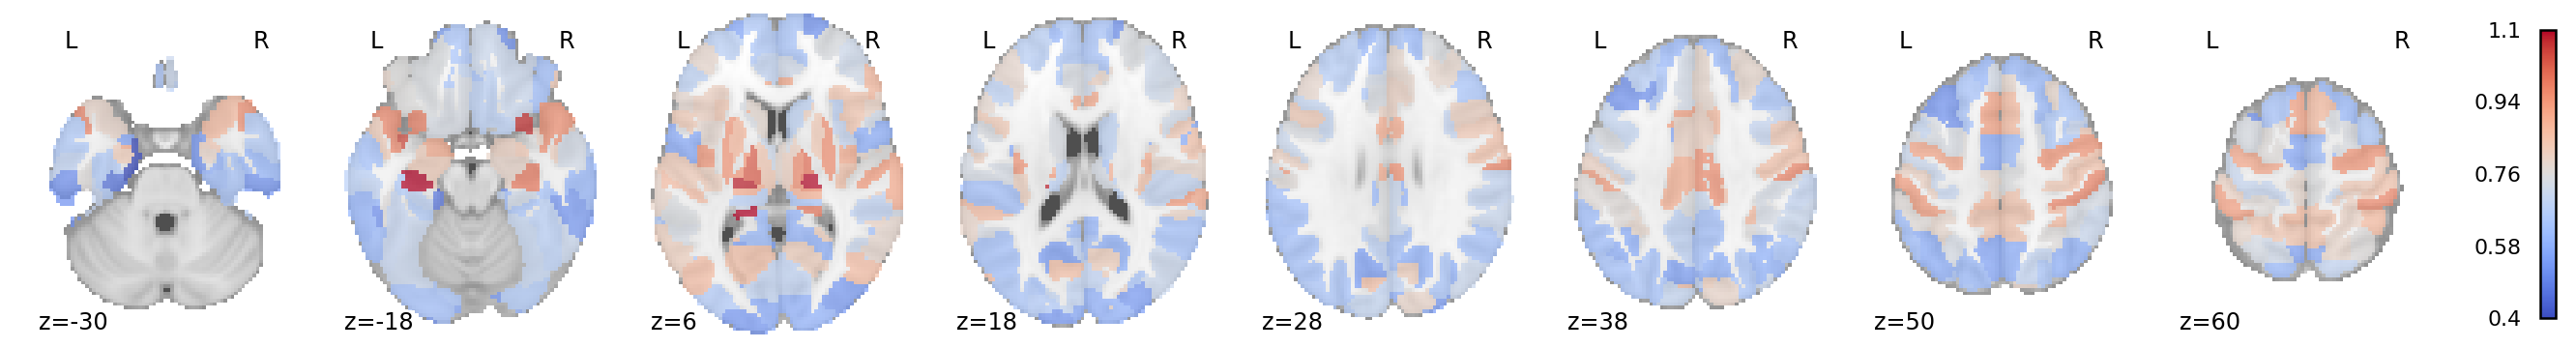

In [33]:
f = plotting.plot_roi(buckner_degz_std_img, display_mode='z',
                           cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60],
                           threshold=1e-5, vmin=buckner_degz_std.min(), vmax=buckner_degz_std.max(),
                           cmap='coolwarm', colorbar=True)

In [34]:
cole_gbcz_std = np.std(cole_gbcz_store, axis=0)

In [35]:
cole_gbcz_std_img = regions.signals_to_img_maps(cole_gbcz_std, BNA_4D)

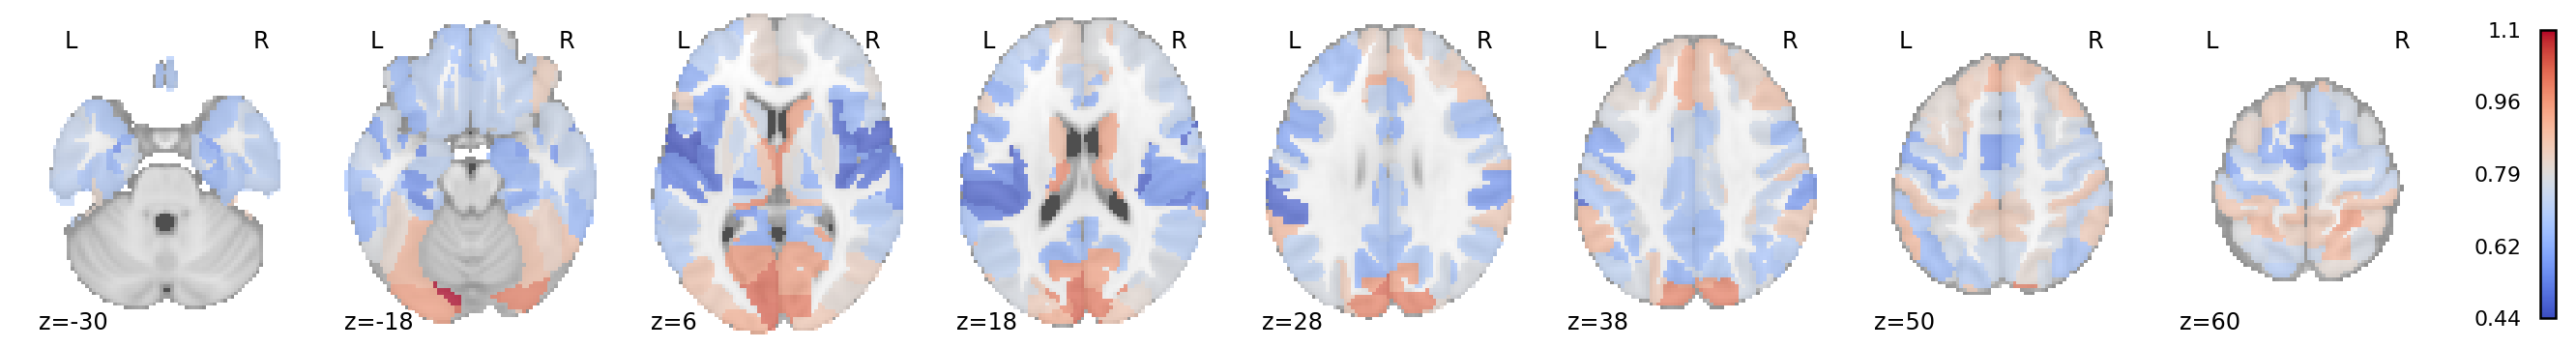

In [36]:
f = plotting.plot_roi(cole_gbcz_std_img, display_mode='z',
                           cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60],
                           threshold=1e-5, vmin=cole_gbcz_std.min(), vmax=cole_gbcz_std.max(),
                           cmap='coolwarm', colorbar=True)

In [37]:
zuo_strengthz_std = np.std(zuo_strengthz_store, axis=0)

In [38]:
zuo_strengthz_std_img = regions.signals_to_img_maps(zuo_strengthz_std, BNA_4D)

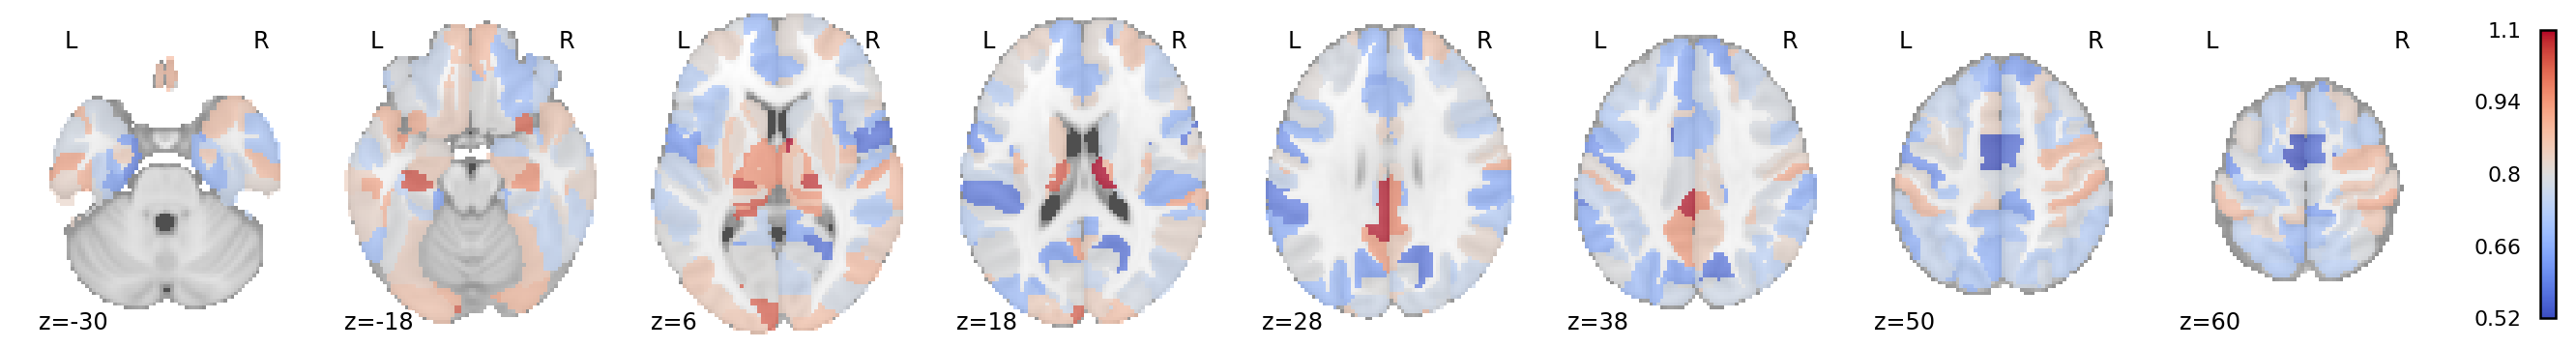

In [39]:
f = plotting.plot_roi(zuo_strengthz_std_img, display_mode='z',
                           cut_coords=[-30, -18, 6, 18, 28, 38, 50, 60],
                           threshold=1e-5, vmin=zuo_strengthz_std.min(), vmax=zuo_strengthz_std.max(),
                           cmap='coolwarm', colorbar=True)

## Comparing Centrality Measures

The various different ways of calculating regional centrality are highly correlated with each other. 

This is perhaps unsurprising, but it is a good reality check to make sure this is actually the case. 

In [40]:
centrality_df = pd.DataFrame([strength_zmean_po, degree_zmean_95bin,
                              buckner_degz_mean, cole_gbcz_mean, zuo_strengthz_mean,
                              buckner_degz_std, cole_gbcz_std, zuo_strengthz_std])

In [41]:
centrality_df = centrality_df.T

In [42]:
centrality_df.columns = ['strength_zmean_po', 'degree_zmean_95bin',
                         'buckner_degz_mean', 'cole_gbcz_mean', 'zuo_strengthz_mean',
                         'buckner_degz_std', 'cole_gbcz_std', 'zuo_strengthz_std']

In [43]:
sns.set_style('white')

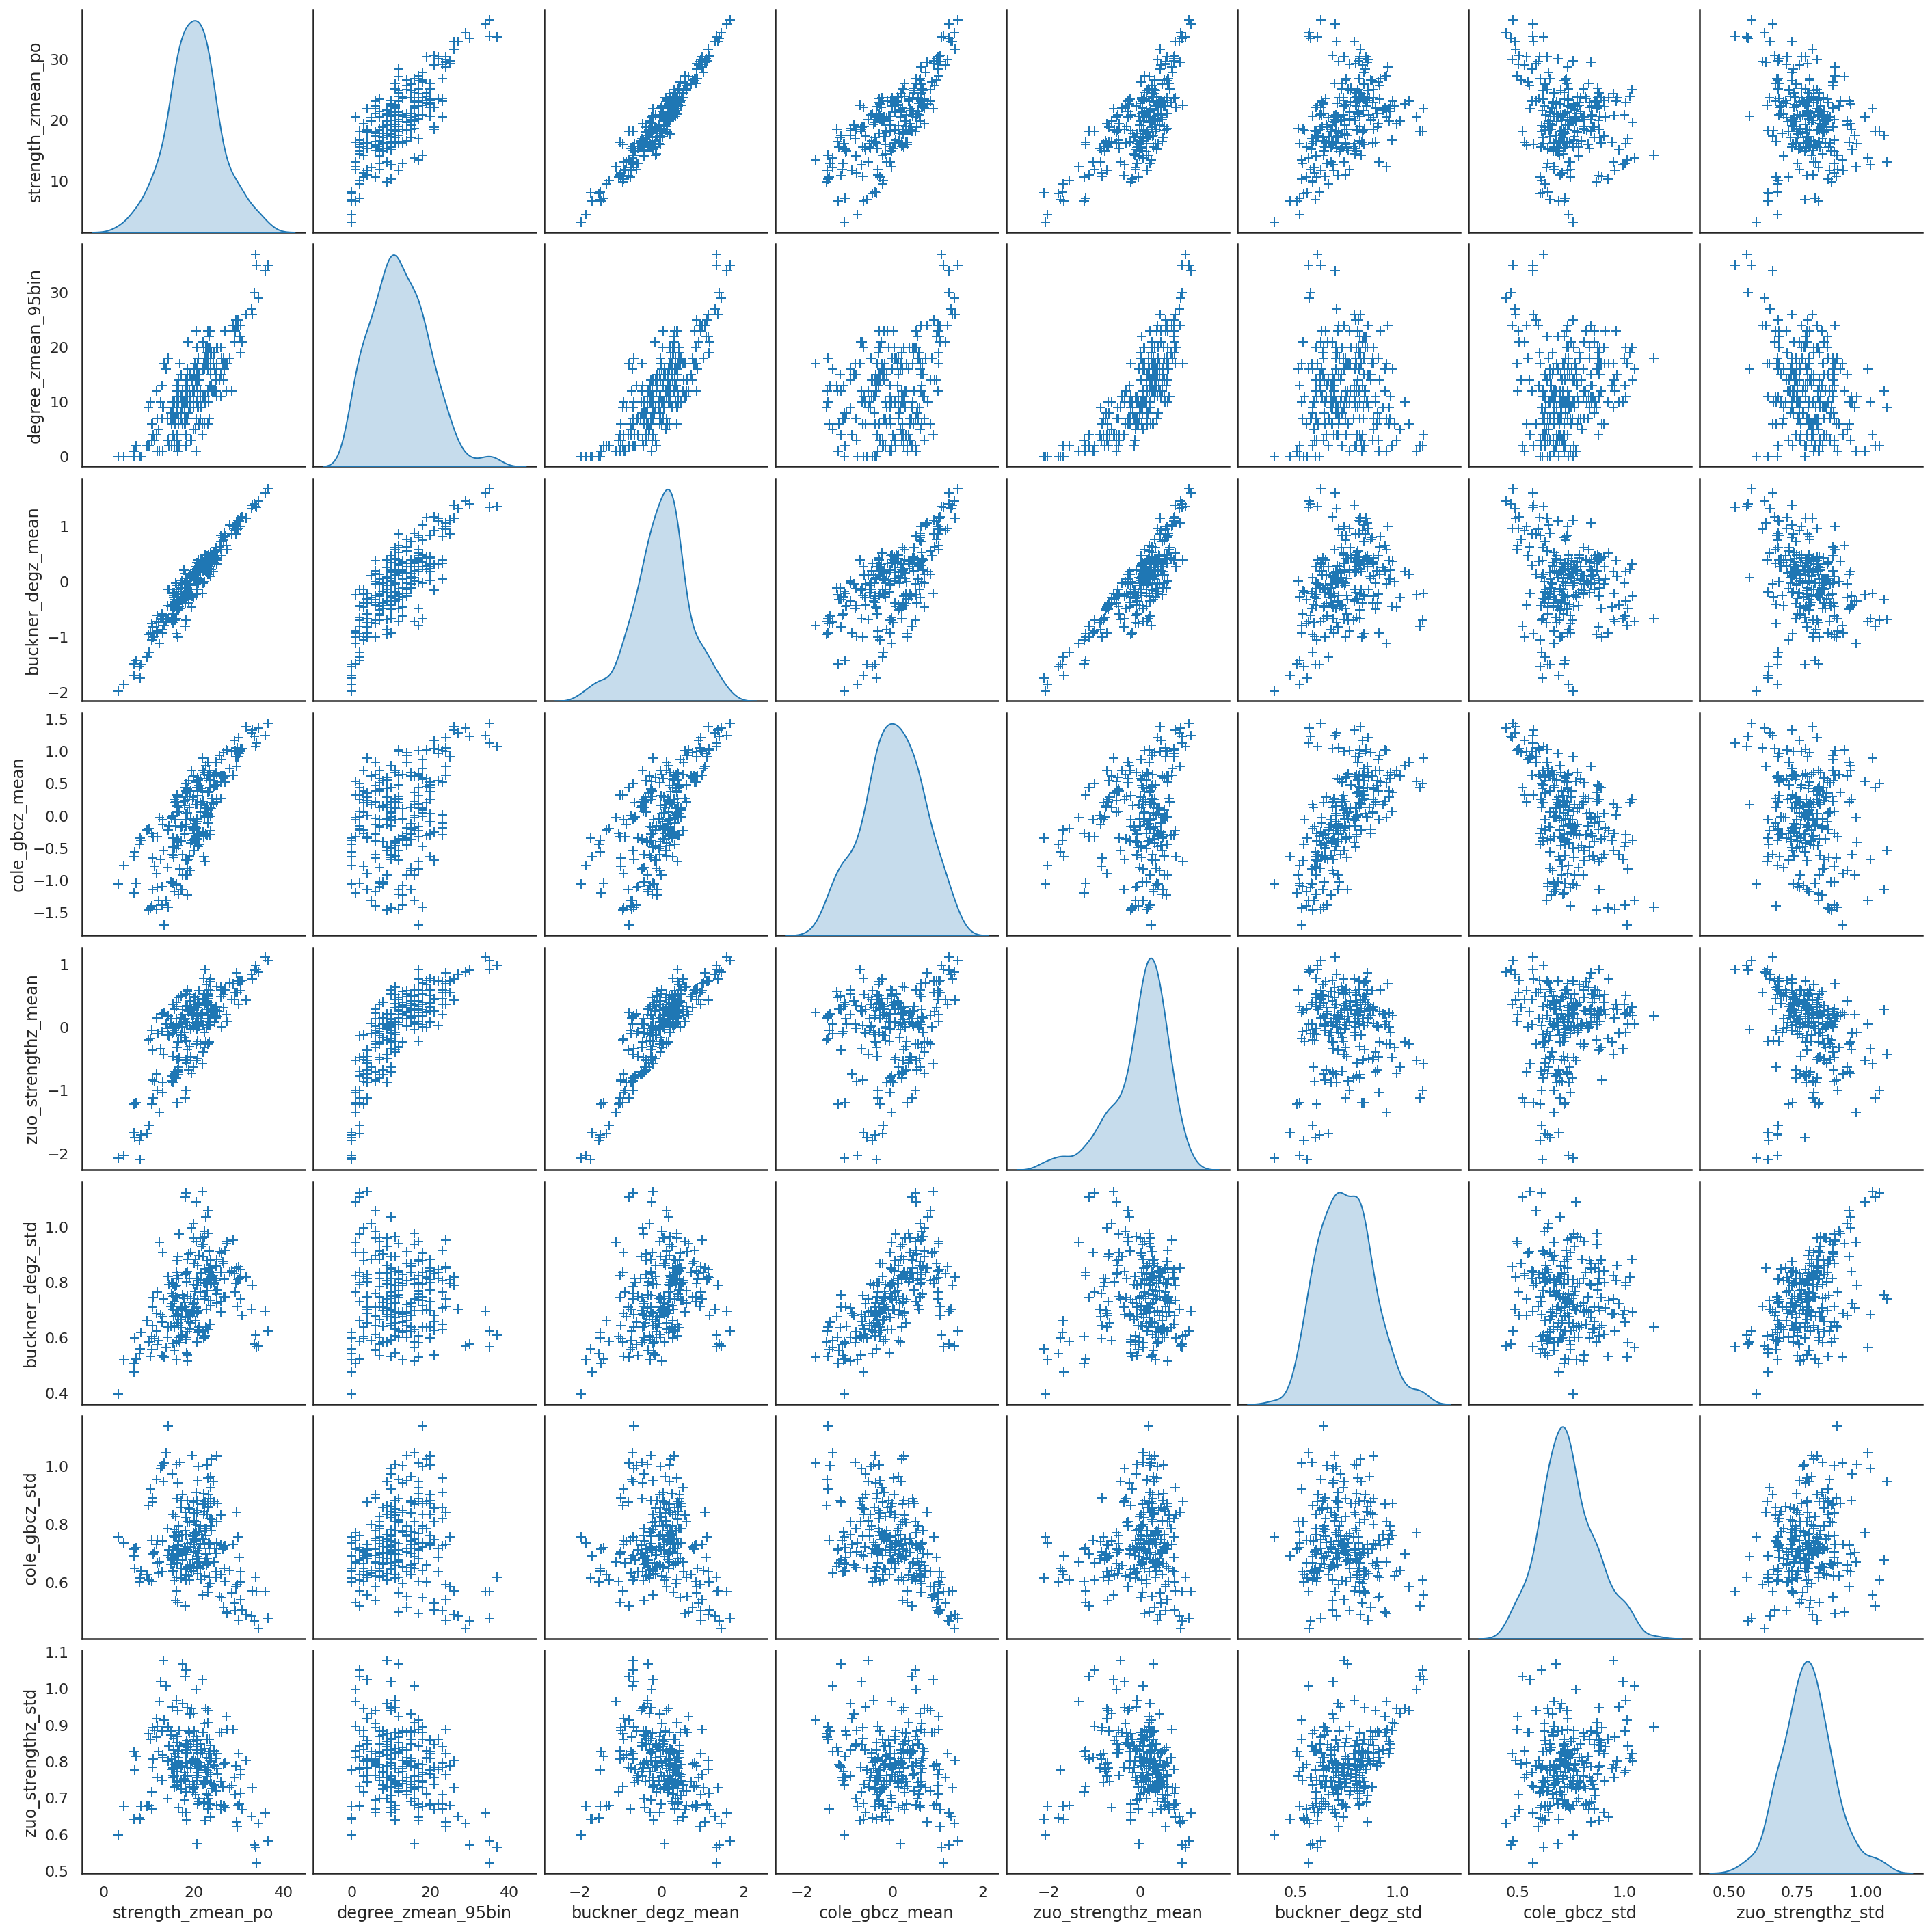

In [44]:
sns.pairplot(centrality_df, diag_kind='kde', markers='+',
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kws=dict(shade=True))

In [45]:
centrality_df.to_csv('/home/despo/dlurie/Projects/timescale_hierarchy/results/functional_connectivity/NKI-1400_HY_CompCorGSR_BNA_degree_df.tsv', sep='\t')